# Problem 3: Singular Value Decomposition and Eigenfaces

In [1]:
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
# Please upload the attface.zip file to the workspace first.
# Refer to the canvas assignment page for a quick guide on how to do upload it.
faces = {}
# load the images dataset
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # opencv load the filename files
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

faceimages = np.asarray(list(faces.values())[0:400:2])
faceimages_test = np.asarray(list(faces.values())[1:401:2])
print(faceimages.shape)
# 3d stands for (index,height,width)
# To make it clear:
# faceimages is a 3d array where the first index is to index the images
# Second and third are to index the image height and width directions.

def plot_single_face(img):
  img_arr = np.reshape(img, (112, 92))
  plt.figure()
  plt.imshow(img_arr, cmap='gray')
  plt.show()



(200, 112, 92)


## Problem 3.1 Constructing the face-image matrix


### $\color{red}{\text{>Important!!!! The following code block is an example for reshaping the the first image into a column vector.<}}$

[[48]
 [49]
 [45]
 ...
 [47]
 [46]
 [46]]


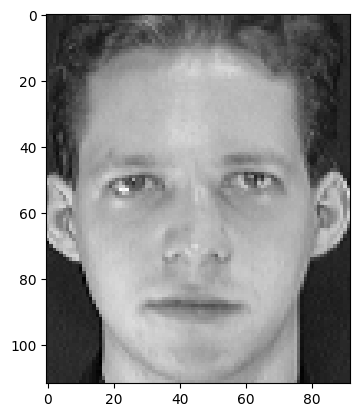

In [2]:
# Check this code! You need to utilize it in your loop for problem 3.1!!!
row_vect = faceimages[[0],:,:] # Take out the 0th face image
col_vect = row_vect.reshape((10304,1))
print(col_vect)
plot_single_face(col_vect)

Shape of the matrix A: (10304, 200)


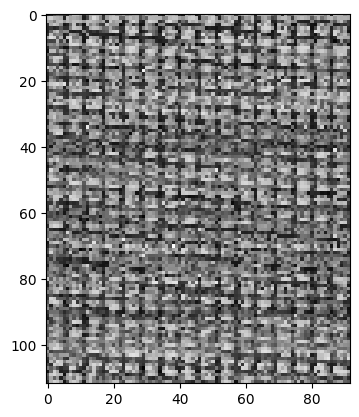

In [3]:
# The shape of faceimages are (200, 112, 92)
# where faceimage[i, :, :] is the i-th face image.
# Please generate the matrix A whose size is (10304, 200) according to face image
# The column vectors of matrix A will stands for the face images.

# Here you can reshape the 3-D array directly followed by a transpose operation
# if you're comfortable with multi-dimensional reshaping operations,
# OR
# you can generate A by writing a for loop [Recommended] (112*92 = 10304)
# please make sure each colums of A represents a face image

# Reshape the 3D array and transpose it to get matrix A
A = faceimages.reshape(112 * 92, -1)

# Print the shape of the generated matrix A
print("Shape of the matrix A:", A.shape)
plot_single_face(A[:, 2]) # Make sure the plot is a human face

## 3.2 PCA on the face-image matrix

In [4]:
def plot_eigenface(B_hat):
  k = B_hat.shape[1]
  fig, axes = plt.subplots(5,4,sharex=True,sharey=True,figsize=(8,10))
  for i in range(k):
    img_tmp = np.reshape(B_hat[:, i], (112, 92))
    axes[i//4][i%4].imshow(img_tmp, cmap="gray")
  plt.show()

In [5]:
# Step(a) center the face-image matrix A according to equation(7) on Page 6
# Calculate the mean face vector
mean_face = np.mean(A, axis=1, keepdims=True)

# Center the face-image matrix A
A_bar = A - mean_face

In [6]:
# Step(b) Perform SVD on A_bar
# This step may take up to 1 min or longer, please be patient to wait.
# Perform SVD on A_bar
U, sigma, V_T = np.linalg.svd(A_bar)

# Print the shapes of U, sigma, and V_T
print("Shapes of U, sigma, V_T:", U.shape, sigma.shape, V_T.shape)

Shapes of U, sigma, V_T: (10304, 10304) (200,) (200, 200)


In [9]:
# Step (c) Using the top k=20 principal components to contruct B_hat and W_hat
# in equation (9) on Page 7
# Hint: Please use np.diag to generate a diagonal matrix if you don't know
# how to generate \Sigma matrix based on eigenvalues (sigma)
# Define k
k = 20

# Construct Sigma matrix from singular values
Sigma = np.diag(sigma)

# Transpose V_T
V_T_transposed = V_T.T

# Take the first k singular values and construct a diagonal matrix
Sigma_k = np.diag(sigma[:k])

# Construct B_hat and W_hat
B_hat = U[:, :k]
W_hat = np.dot(Sigma_k, V_T_transposed[:k, :])

# Print the shapes of B_hat and W_hat
print("Shapes of B_hat and W_hat:", B_hat.shape, W_hat.shape)

Shapes of B_hat and W_hat: (10304, 20) (20, 200)


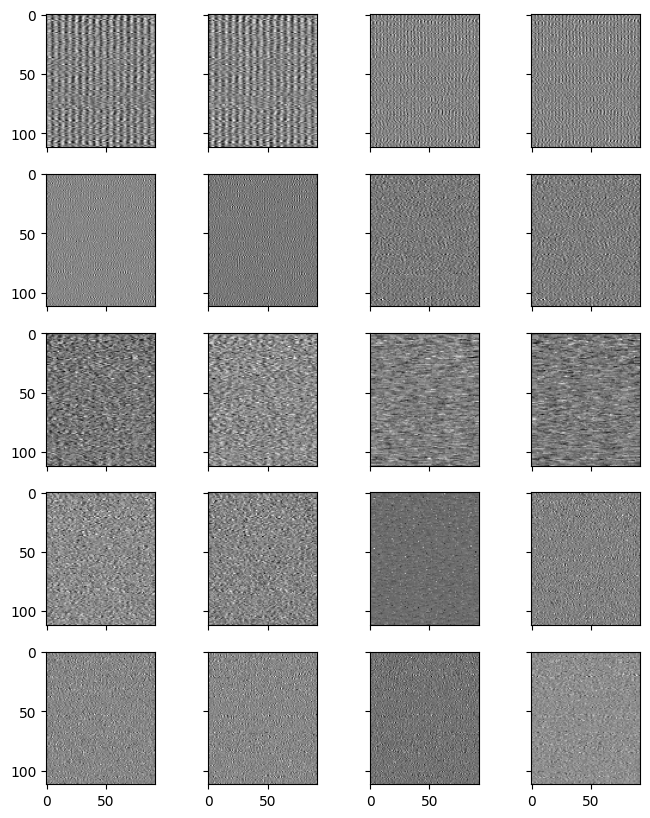

In [10]:
# Step (d) Plot the B_hat components
plot_eigenface(B_hat)

## Problem 3.3 Face recognition based on eigenfaces

In [11]:
def visualize_recognition(ind, test_img, faceimages):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(np.squeeze(test_img, axis=0), cmap="gray") # Updated here
  plt.subplot(1, 2, 2)
  best_match = faceimages[ind, :, :]
  plt.imshow(best_match, cmap="gray")
  plt.show()

In [12]:
# Here are 3 test images
test_img1 = faceimages_test[[15], :, :]
test_img2 = faceimages_test[[35], :, :]
test_img3 = faceimages_test[[75], :, :]

In [14]:
# Step(a) Vectorize 3 test images
z_1 = test_img1.reshape((-1, 1))
z_2 = test_img2.reshape((-1, 1))
z_3 = test_img3.reshape((-1, 1))

In [15]:
# Step (b) Center each of the 3 vectors according to equation (10)
mean_vector = np.mean(A, axis=1)
z_1_bar = z_1 - mean_vector.reshape((-1, 1))
z_2_bar = z_2 - mean_vector.reshape((-1, 1))
z_3_bar = z_3 - mean_vector.reshape((-1, 1))

In [16]:
# Step (c) Compute the representations of the 3 vectors with respect to the B_hat
w_1 = np.dot(B_hat.T, z_1_bar)
w_2 = np.dot(B_hat.T, z_2_bar)
w_3 = np.dot(B_hat.T, z_3_bar)

In [17]:
# Step (d) Find the nearest neighbors
distances_1 = np.linalg.norm(W_hat - w_1.reshape(-1, 1), axis=0)
ind_1 = np.argmin(distances_1)

distances_2 = np.linalg.norm(W_hat - w_2.reshape(-1, 1), axis=0)
ind_2 = np.argmin(distances_2)

distances_3 = np.linalg.norm(W_hat - w_3.reshape(-1, 1), axis=0)
ind_3 = np.argmin(distances_3)

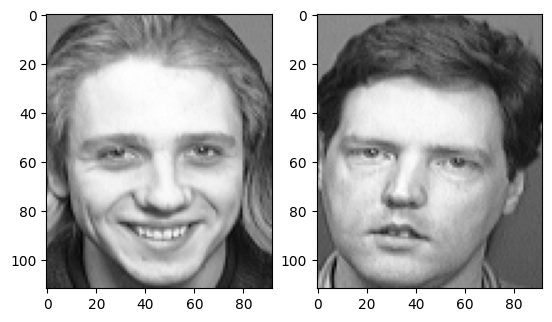

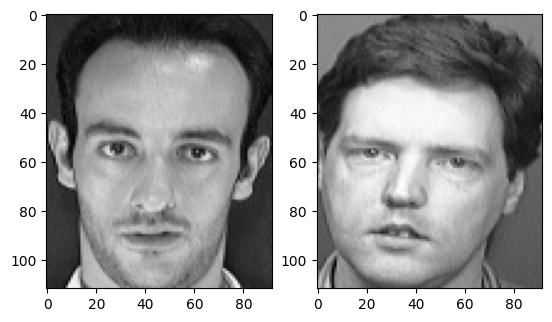

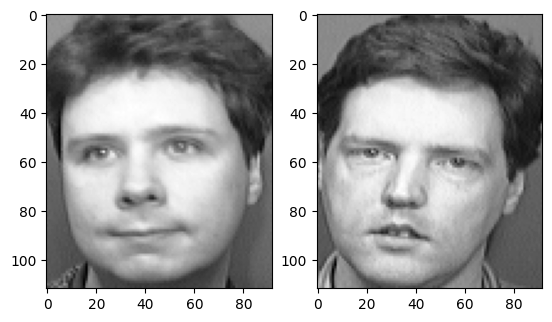

In [18]:
visualize_recognition(ind_1, test_img1, faceimages)
visualize_recognition(ind_2, test_img2, faceimages)
visualize_recognition(ind_3, test_img3, faceimages)

# 3.4 (Extra Credit) Image compression using the SVD

In [19]:
# function that plots an image that is in a 2D array format
def visualize_rec_img(img):
  plt.figure()
  plt.imshow(img, cmap='gray')
  plt.show()

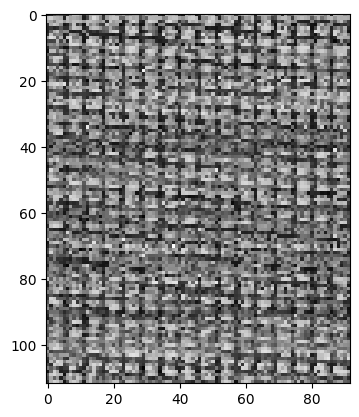

In [20]:
# image we want to compress
img = np.reshape(A[:,2], (112,92))
visualize_rec_img(img)

##Compressing the images and visualizing them

In [23]:
# Assuming A is your image matrix
# Example: A = np.loadtxt('image.txt')  # Load your image from a file if it's not already in memory

# Compute the SVD of the image matrix A
U, Sigma, Vt = np.linalg.svd(A, full_matrices=False)

# the number of singular values and vectors we want to look at
num_singular_values = [1, 5, 10, 15, 20, 40, 92]
compressed_imgs = []
entries_stored = []

# compare the outputs of the different compressions
for k in num_singular_values:
    # Construct the compressed image Ak
    Uk = U[:, :k]
    Sk = np.diag(Sigma[:k])
    Vk = Vt[:k, :]
    Ak = np.dot(Uk, np.dot(Sk, Vk))

    # Count the number of values needed to store Ak
    storage = Uk.size + Sk.size + Vk.size
    entries_stored.append(storage)

    # Append the compressed image to the list
    compressed_imgs.append(Ak)




Compression using largest 1 singular values:



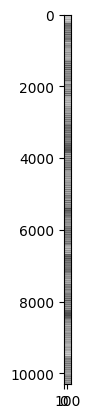




Compression using largest 5 singular values:



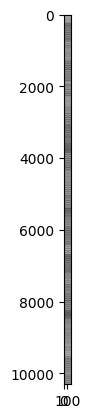




Compression using largest 10 singular values:



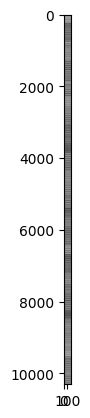




Compression using largest 15 singular values:



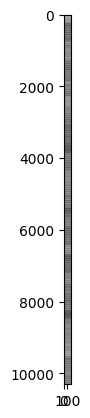




Compression using largest 20 singular values:



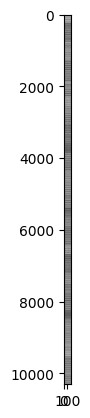




Compression using largest 40 singular values:



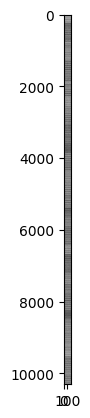




Compression using largest 92 singular values:



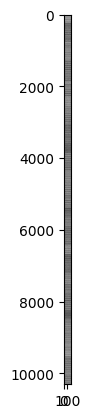

In [24]:
for i in range(len(compressed_imgs)):
  print(f"\n\n\nCompression using largest {num_singular_values[i]} singular values:\n")
  visualize_rec_img(compressed_imgs[i])

## TODO:
### What do you observe about the way the image looks with respect to the how many of the largest singular values and their respective singular vectors we use to reconstruct it? What information seems to be carried by the largest singular values and their respective singular vectors and what seems to be carried by the smallest singular values and their respective vectors?

When we use fewer singular values, the reconstructed image loses fine detials and appears more pixelated. As we increase the number of singular values, the image tends to become sharper and closer to the original. Too many singular values though can lead to overfitting. Largest singular values primarily capture dominant feautures and structures within the image. Smallest singular values capture finer details and textures in the image.

### Comparing storage for different the compressed images with respect to how many of the largest singular values and their respective singular vectors are used to reconstruct the image.

In [25]:
for i in range(len(num_singular_values)):
  print(f"Entries stored for compression using {num_singular_values[i]} largest singular values: {entries_stored[i]}")

Entries stored for compression using 1 largest singular values: 10505
Entries stored for compression using 5 largest singular values: 52545
Entries stored for compression using 10 largest singular values: 105140
Entries stored for compression using 15 largest singular values: 157785
Entries stored for compression using 20 largest singular values: 210480
Entries stored for compression using 40 largest singular values: 421760
Entries stored for compression using 92 largest singular values: 974832


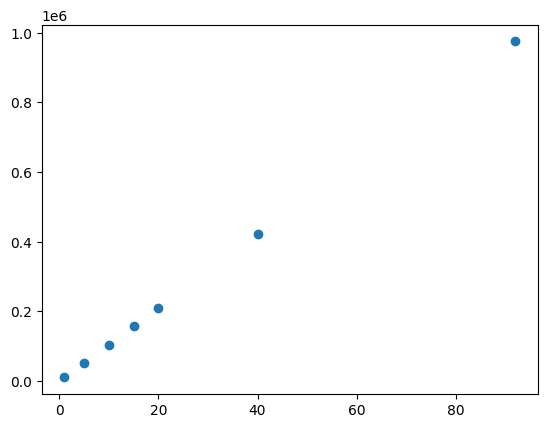

In [26]:
# plot number of singular values vs storage
plt.figure()
plt.scatter(num_singular_values, entries_stored)
plt.show()

## TODO:
### What kind of relationship do you think exist between the number of entries stored and the number of singular values used to reconstruct the image?



Based on the plot, it appears that there is an increase in the storage used as the number of singular values increase.

### Choosing the compressed image

Original image: 


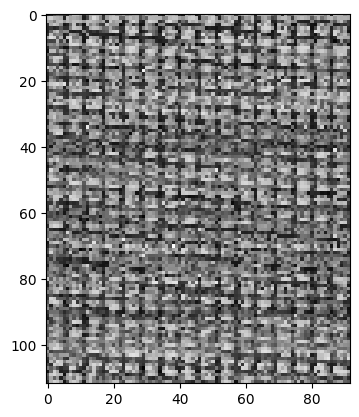



Chosen compressed image:


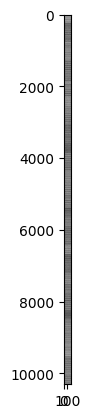



Storage space used relative to the original image: 9461%
Original image: 


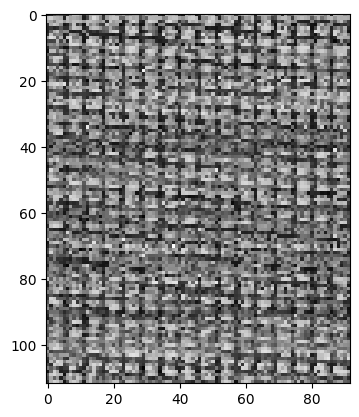



Chosen compressed image:


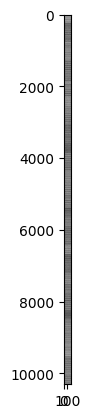



Storage space used relative to the original image 9461%


In [27]:
chosen_k = 92
index = num_singular_values.index(chosen_k)
print("Original image: ")
visualize_rec_img(img)
print("\n\nChosen compressed image:")
visualize_rec_img(compressed_imgs[index])
print(f"\n\nStorage space used relative to the original image: {100*(entries_stored[index]/(112*92)):.0f}%")

index = num_singular_values.index(chosen_k)
print("Original image: ")
visualize_rec_img(img)
print("\n\nChosen compressed image:")
visualize_rec_img(compressed_imgs[index])
print(f"\n\nStorage space used relative to the original image {100*(entries_stored[index]/(112*92)):.0f}%")